# Evaluating Cellpose 'Cyto3' model trained with manual annotations of 'Toy2' Subset


Exploration of stepwise reduced image resolution on the accuracy of cell segmentation. Segmentation performance evaluated from 1200x1600 to 60x80 pixels using Dice, F1, and Panoptic Quality Scores at both the pixel and cell levels.

For the evaluation dataset, 23 resolution levels (90\%-20\% in 10\% intervals, 20\%-5\% in 1\% intervals) are generated for detailed analysis.

## Code Credits and Implementation Details

1.  Stringer et al. Foundational notebook structure: https://github.com/MouseLand/cellpose?tab=readme-ov-file, Cellpose Team. Cellpose Code. Available at: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/runcellpose2.ipynb. Accessed: 2024-12-30.
2.  Sreenu, B. N. Python for Microscopists: Cellpose Algorithm for
Segmentation. Available at: https://github.com/bnsreenu/pythonformicroscopists/blob/master/305WhatisCellposealgorithmforsegmentation.ipynb: Accessed: 2024-12-30. - Functions: writing quality control metrics
3. Evaluation Metric from Stardist Matching Implementation: Uwe Schmidt, Patrick K¨ohler, and others, ”StarDist: Matching Imple-
mentation,” 2021, https://github.com/stardist/stardist/blob/main/stardist/matching.py. Accessed: 2024-12-30.


Remaining authors implementation: Adaptation of quality control metrics code (Dice Score, Panoptic Score etc.), Extension (Dice Score) in stardist/matching.py, get_diameter_for_image(), calculate_dice(), calculate_diameter(), all matplot plots in visualization chapter

## Installation

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install stardist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
albumentations 1.4.20 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
from skimage.measure import label
from skimage.segmentation import relabel_sequential
import numpy as np
import csv
from astropy.visualization import simple_norm
from ipywidgets import interact
import pandas as pd
from tabulate import tabulate

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Dec 31 20:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  7

## Mount google drive


In [3]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Use custom model to segment images


## Parameters

In [4]:
# model name and path

#@markdown ###Custom model path (full path):
model_path = "/content/gdrive/MyDrive/CELLPOSE//content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/train/models/malaria" #@param {type:"string"}

#@markdown ###Path to images:

dir = "/content/gdrive/MyDrive/CELLPOSE/dataset_09/eval" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "None" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  46#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


In [5]:
import math

# Predefined mapping of dimensions to diameters
dimension_to_diameter = {
    '1200x1600': 45,
    '1080x1440': 40.5,
    '960x1280': 36.0,
    '840x1120': 31.5,
    '720x960': 27.0,
    '600x800': 22.5,
    '480x640': 18.0,
    '360x480': 13.5,
    '240x320': 9.0,
    '228x304': 8.55,
    '216x288': 8.1,
    '204x272': 7.65,
    '192x256': 7.2,
    '180x240': 6.75,
    '168x224': 6.3,
    '156x208': 5.85,
    '144x192': 5.4,
    '132x176': 4.95,
    '120x160': 4.5,
    '108x144': 4.05,
    '96x128': 3.6,
    '84x112': 3.15,
    '72x96': 2.7,
    '60x80': 2.25,
    '48x64': 1.8,
    '36x48': 1.35,
    '24x32': 0.9,
    '12x16': 0.45
}

resolution = {
    '1200x1600': 100,
    '1080x1440': 90,
    '960x1280': 80,
    '840x1120': 70,
    '720x960': 60,
    '600x800': 50,
    '480x640': 40,
    '360x480': 30,
    '240x320': 20,
    '228x304': 19,
    '216x288': 18,
    '204x272': 17,
    '192x256': 16,
    '180x240': 15,
    '168x224': 14,
    '156x208': 13,
    '144x192': 12,
    '132x176': 11,
    '120x160': 10,
    '108x144': 9,
    '96x128': 8,
    '84x112': 7,
    '72x96': 6,
    '60x80': 5,
    '48x64': 4,
    '36x48': 3,
    '24x32': 2,
    '12x16': 1
}



# Function to calculate the diameter for unknown dimensions
def calculate_diameter(height, width):
    # Use a proportional constant based on a known reference dimension
    reference_key = "1200x1600"
    reference_diameter = dimension_to_diameter[reference_key]
    reference_height, reference_width = map(int, reference_key.split('x'))

    # Calculate the diagonal of the reference dimension and the given dimension
    reference_diagonal = math.sqrt(reference_height**2 + reference_width**2)
    given_diagonal = math.sqrt(height**2 + width**2)

    # Scale the diameter proportionally
    return (given_diagonal / reference_diagonal) * reference_diameter

# Function to determine the diameter based on image dimensions
def get_diameter_for_image(image, dimension_to_diameter):
    height, width = image.shape[:2]
    dimension_key = f"{height}x{width}"
    if dimension_key in dimension_to_diameter:
        return dimension_to_diameter[dimension_key]
    else:
        # Calculate the diameter for unknown dimensions
        return calculate_diameter(height, width)


## run custom model


In [6]:
# Load test images
output = io.load_train_test_data(dir, mask_filter='_masks')
test_data, test_labels = output[:2]

# Retrieve the list of test file names
test_data_files = output[2]  # The function returns file names as the third component

# Optional: Extract only the base names (without the path)
test_data_files = [os.path.basename(f) for f in test_data_files]

# Display the loaded file names
print("Test files:", test_data_files)
print(len(test_data_files))

Test files: ['T02_Sample1_R.tiff', 'T02_Sample1_R_res0_1.tiff', 'T02_Sample1_R_res0_2.tiff', 'T02_Sample1_R_res0_3.tiff', 'T02_Sample1_R_res0_4.tiff', 'T02_Sample1_R_res0_05.tiff', 'T02_Sample1_R_res0_5.tiff', 'T02_Sample1_R_res0_6.tiff', 'T02_Sample1_R_res0_06.tiff', 'T02_Sample1_R_res0_07.tiff', 'T02_Sample1_R_res0_7.tiff', 'T02_Sample1_R_res0_8.tiff', 'T02_Sample1_R_res0_08.tiff', 'T02_Sample1_R_res0_9.tiff', 'T02_Sample1_R_res0_09.tiff', 'T02_Sample1_R_res0_11.tiff', 'T02_Sample1_R_res0_12.tiff', 'T02_Sample1_R_res0_13.tiff', 'T02_Sample1_R_res0_14.tiff', 'T02_Sample1_R_res0_15.tiff', 'T02_Sample1_R_res0_16.tiff', 'T02_Sample1_R_res0_17.tiff', 'T02_Sample1_R_res0_18.tiff', 'T02_Sample1_R_res0_19.tiff', 'T02_Sample1_S.tiff', 'T02_Sample1_S_res0_1.tiff', 'T02_Sample1_S_res0_2.tiff', 'T02_Sample1_S_res0_3.tiff', 'T02_Sample1_S_res0_4.tiff', 'T02_Sample1_S_res0_5.tiff', 'T02_Sample1_S_res0_05.tiff', 'T02_Sample1_S_res0_6.tiff', 'T02_Sample1_S_res0_06.tiff', 'T02_Sample1_S_res0_7.tiff',

In [7]:
# Declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# Use model diameter if user-specified diameter is 0
diameter = model.diam_labels if diameter == 0 else diameter

# Collect results
results = []

for i, img in enumerate(test_data):
    # Ensure the correct format and determine the appropriate diameter
    if img.shape[0] == 3:  # Channels are in the first position (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C)
    elif img.shape[-1] != 3:  # If the number of channels is not correct
        raise ValueError(f"Unexpected image shape: {img.shape}. Expected a 3-channel image.")

    diameter = get_diameter_for_image(img, dimension_to_diameter)
    # Run the model
    masks = model.eval(img, channels=[chan, chan2], diameter=diameter)[0]
    if masks.ndim != 2:
        print(f"Warning: Mask {i} is not 2D. Shape: {masks.shape}")

    # Save the mask as a NumPy file
    mask_file = os.path.join(dir, f"mask_{i}.npy")
    np.save(mask_file, masks)

    # Calculate average precision
    ap = metrics.average_precision([test_labels[i]], [masks])[0]

    # Store results
    results.append({
        "Image": test_data_files[i],
        "Dimensions": f"{img.shape[0]}x{img.shape[1]}x{img.shape[2]}",
        "Diameter": round(diameter, 2),
        "AP": round(ap[:, 0].mean(), 3)
    })
    # Uncomment to print details
    # print(f"Image: {test_data_files[i]}, Dimensions: {img.shape[0]}x{img.shape[1]}, Diameter: {diameter:.2f}, AP: {ap[:, 0].mean():.3f}")


100%|██████████| 25.3M/25.3M [00:02<00:00, 8.86MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

In [8]:
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

                          Image   Dimensions  Diameter     AP
0            T02_Sample1_R.tiff  1200x1600x3     45.00  0.939
1     T02_Sample1_R_res0_1.tiff      60x80x3      2.25  0.000
2     T02_Sample1_R_res0_2.tiff    192x256x3      7.20  0.842
3     T02_Sample1_R_res0_3.tiff    360x480x3     13.50  0.912
4     T02_Sample1_R_res0_4.tiff    480x640x3     18.00  0.919
..                          ...          ...       ...    ...
355  T11_Sample3_T_res0_50.tiff    600x800x3     22.50  0.980
356  T11_Sample3_T_res0_60.tiff    720x960x3     27.00  0.981
357  T11_Sample3_T_res0_70.tiff   840x1120x3     31.50  0.981
358  T11_Sample3_T_res0_80.tiff   960x1280x3     36.00  0.980
359  T11_Sample3_T_res0_90.tiff  1080x1440x3     40.50  0.981

[360 rows x 4 columns]


# EVALUATION

In [9]:
def calculate_dice(gt, pred):
    """Calculate the Dice coefficient based on ground truth and predicted masks."""
    gt_mask = np.where(gt > 0, 1, 0)  # Convert ground truth to binary mask
    pred_mask = np.where(pred > 0, 1, 0)  # Convert prediction to binary mask
    intersection = np.logical_and(gt_mask, pred_mask)  # Calculate the intersection
    union = np.logical_or(gt_mask, pred_mask)  # Calculate the sum of both masks

    return 2 * np.sum(intersection) / (np.sum(intersection) + np.sum(union))  if (np.sum(intersection) + np.sum(union)) > 0 else 0

In [10]:
loaded_masks = []
for i in range(len(test_data_files)):
    mask_file = os.path.join(dir, f"mask_{i}.npy")
    mask = np.load(mask_file)
    if mask.ndim != 2:
        print(f"Warning: Loaded mask {i} has invalid shape {mask.shape}. Reshaping...")
    loaded_masks.append(mask)
    #print(f"Mask {i} loaded with shape {mask.shape}")

In [11]:
## https://github.com/stardist/stardist/blob/main/stardist/matching.py
# @author: Extension dice_coefficient()

import numpy as np

from numba import jit
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from skimage.measure import regionprops
from collections import namedtuple
from csbdeep.utils import _raise

matching_criteria = dict()
def label_are_sequential(y):
    """ returns true if y has only sequential labels from 1... """
    labels = np.unique(y)
    return (set(labels)-{0}) == set(range(1,1+labels.max()))


def is_array_of_integers(y):
    return isinstance(y,np.ndarray) and np.issubdtype(y.dtype, np.integer)


def _check_label_array(y, name=None, check_sequential=False):
    err = ValueError("{label} must be an array of {integers}.".format(
        label = 'labels' if name is None else name,
        integers = ('sequential ' if check_sequential else '') + 'non-negative integers',
    ))
    is_array_of_integers(y) or _raise(err)
    if len(y) == 0:
        return True
    if check_sequential:
        label_are_sequential(y) or _raise(err)
    else:
        y.min() >= 0 or _raise(err)
    return True


def label_overlap(x, y, check=True):
    if check:
        _check_label_array(x,'x',True)
        _check_label_array(y,'y',True)
        x.shape == y.shape or _raise(ValueError("x and y must have the same shape"))
    return _label_overlap(x, y)

@jit(nopython=True)
def _label_overlap(x, y):
    x = x.ravel()
    y = y.ravel()
    overlap = np.zeros((1+x.max(),1+y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1
    return overlap


def _safe_divide(x,y, eps=1e-10):
    """computes a safe divide which returns 0 if y is zero"""
    if np.isscalar(x) and np.isscalar(y):
        return x/y if np.abs(y)>eps else 0.0
    else:
        out = np.zeros(np.broadcast(x,y).shape, np.float32)
        np.divide(x,y, out=out, where=np.abs(y)>eps)
        return out


def intersection_over_union(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return _safe_divide(overlap, (n_pixels_pred + n_pixels_true - overlap))

matching_criteria['iou'] = intersection_over_union

def dice_coefficient(overlap):
    _check_label_array(overlap, 'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return _safe_divide(2 * overlap, (n_pixels_pred + n_pixels_true))

matching_criteria['dice'] = dice_coefficient

def precision(tp,fp,fn):
    return tp/(tp+fp) if tp > 0 else 0
def recall(tp,fp,fn):
    return tp/(tp+fn) if tp > 0 else 0
def accuracy(tp,fp,fn):
    # also known as "average precision" (?)
    # -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
    return tp/(tp+fp+fn) if tp > 0 else 0
def f1(tp,fp,fn):
    # also known as "dice coefficient"
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0

def matching(y_true, y_pred, thresh=0.5, criterion='iou', report_matches=False):
    """Calculate detection/instance segmentation metrics between ground truth and predicted label images.

    Currently, the following metrics are implemented:

    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'

    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)

    * mean_matched_score is the mean IoUs of matched true positives

    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects

    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019

    Parameters
    ----------
    y_true: ndarray
        ground truth label image (integer valued)
    y_pred: ndarray
        predicted label image (integer valued)
    thresh: float
        threshold for matching criterion (default 0.5)
    criterion: string
        matching criterion (default IoU)
    report_matches: bool
        if True, additionally calculate matched_pairs and matched_scores (note, that this returns even gt-pred pairs whose scores are below  'thresh')

    Returns
    -------
    Matching object with different metrics as attributes

    Examples
    --------
    >>> y_true = np.zeros((100,100), np.uint16)
    >>> y_true[10:20,10:20] = 1
    >>> y_pred = np.roll(y_true,5,axis = 0)

    >>> stats = matching(y_true, y_pred)
    >>> print(stats)
    Matching(criterion='iou', thresh=0.5, fp=1, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=1, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0)

    """
    _check_label_array(y_true,'y_true')
    _check_label_array(y_pred,'y_pred')
    y_true.shape == y_pred.shape or _raise(ValueError("y_true ({y_true.shape}) and y_pred ({y_pred.shape}) have different shapes".format(y_true=y_true, y_pred=y_pred)))
    criterion in matching_criteria or _raise(ValueError("Matching criterion '%s' not supported." % criterion))
    if thresh is None: thresh = 0
    thresh = float(thresh) if np.isscalar(thresh) else map(float,thresh)

    y_true, _, map_rev_true = relabel_sequential(y_true)
    y_pred, _, map_rev_pred = relabel_sequential(y_pred)

    overlap = label_overlap(y_true, y_pred, check=False)
    scores = matching_criteria[criterion](overlap)
    assert 0 <= np.min(scores) <= np.max(scores) <= 1

    # ignoring background
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    def _single(thr):
        # not_trivial = n_matched > 0 and np.any(scores >= thr)
        not_trivial = n_matched > 0
        if not_trivial:
            # compute optimal matching with scores as tie-breaker
            costs = -(scores >= thr).astype(float) - scores / (2*n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            assert n_matched == len(true_ind) == len(pred_ind)
            match_ok = scores[true_ind,pred_ind] >= thr
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        fp = n_pred - tp
        fn = n_true - tp
        assert tp+fp == n_pred
        assert tp+fn == n_true

        # the score sum over all matched objects (tp)
        sum_matched_score = np.sum(scores[true_ind,pred_ind][match_ok]) if not_trivial else 0.0

        # the score average over all matched objects (tp)
        mean_matched_score = _safe_divide(sum_matched_score, tp)
        # the score average over all gt/true objects
        mean_true_score    = _safe_divide(sum_matched_score, n_true)
        panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

        stats_dict = dict (
            criterion          = criterion,
            thresh             = thr,
            fp                 = fp,
            tp                 = tp,
            fn                 = fn,
            precision          = precision(tp,fp,fn),
            recall             = recall(tp,fp,fn),
            accuracy           = accuracy(tp,fp,fn),
            f1                 = f1(tp,fp,fn),
            n_true             = n_true,
            n_pred             = n_pred,
            mean_true_score    = mean_true_score,
            mean_matched_score = mean_matched_score,
            panoptic_quality   = panoptic_quality,
        )
        if bool(report_matches):
            if not_trivial:
                stats_dict.update (
                    # int() to be json serializable
                    matched_pairs  = tuple((int(map_rev_true[i]),int(map_rev_pred[j])) for i,j in zip(1+true_ind,1+pred_ind)),
                    matched_scores = tuple(scores[true_ind,pred_ind]),
                    matched_tps    = tuple(map(int,np.flatnonzero(match_ok))),
                )
            else:
                stats_dict.update (
                    matched_pairs  = (),
                    matched_scores = (),
                    matched_tps    = (),
                )
        return namedtuple('Matching',stats_dict.keys())(*stats_dict.values())

    return _single(thresh) if np.isscalar(thresh) else tuple(map(_single,thresh))



In [12]:
from stardist.matching import relabel_sequential

QC_model_folder = dir + "/Quality Control"
csv_path = os.path.join(QC_model_folder, "Quality_Control.csv")

# Create the folder if it does not exist
os.makedirs(QC_model_folder, exist_ok=True)

# List of image names
image_names = [os.path.basename(f) for f in test_data_files]  # Get the base names of the test files

# Open the CSV file for writing quality control metrics
with open(csv_path, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image", "Dice (Pix-Lev)", "Panoptic_quality", "TP", "FP",
                     "FN", "Precision", "Recall", "F1 Score",
                     "#Cells GT", '#Cells Pred', "Pixel Dimensions", "Pixel Diameter"])


    for i, (gt, pred) in enumerate(zip(test_labels, loaded_masks)):
        # Use the correct file name
        image_name = image_names[i]
        # Re-label the GT and Pred images to avoid label mismatches
        gt, _, _ = relabel_sequential(gt)
        pred, _, _ = relabel_sequential(pred)
        # calculation at cell-instance level to determine if the cell is a tp based on thresh
        stats = matching(gt, pred, thresh=0.8, criterion='dice')
        #print("Einzigartige Labels:", unique_labels_pred)

        # Pixel dimensions of the image
        pixel_dimensions = f"{gt.shape[0]}x{gt.shape[1]}"  # Height x Width

        # Determine the appropriate diameter based on the dimensions
        diameter = get_diameter_for_image(gt, dimension_to_diameter)

        # Calculate IoU and dice - pixel-level to the binary masks of GT and Pred - overall overlap and similarity of the two masks
        #iou_score = calculate_iou(gt, pred)
        dice_score = calculate_dice(gt, pred)

        # Write metrics to CSV
        writer.writerow([image_name, round(dice_score,3), round(stats.panoptic_quality,3), stats.tp, stats.fp, stats.fn,
                         round(stats.precision,3), round(stats.recall, 3), round(stats.f1, 3),
                         stats.n_true, stats.n_pred, pixel_dimensions, diameter])

# Display the QC table
df = pd.read_csv(csv_path)
# Interactive display of QC results
@interact
def show_QC_results(file=image_names):
    """
    Interactive display of results: input, ground truth, predictions, and metrics.
    """
    # Get the index of the selected test image based on file name
    idx = image_names.index(file)

    source_image = test_data[idx]
    target_image = test_labels[idx]
    prediction = loaded_masks[idx]

    # Retrieve IoU score for display
    #iou_score = df.loc[df['Image'] == file, 'IoU'].values[0]
    #dice_score = df.loc[df['Image'] == file, 'Dice'].values[0]
    # Normalize the source image for display
    norm = simple_norm(source_image, percent=99)

    # Convert ground truth and prediction to binary masks (0 or 255)
    target_image_mask = np.where(target_image > 0, 255, 0)
    prediction_mask = np.where(prediction > 0, 255, 0)

    # Display results
    plt.figure(figsize=(25, 5))

    # Input image
    plt.subplot(1, 4, 1)
    plt.axis('off')
    if source_image.ndim == 3 and source_image.shape[0] == 3:  # Channels in the first dimension
        source_image = source_image.transpose(1, 2, 0)  # Convert to (height, width, channels)

    # Scale for `imshow`
    if source_image.dtype != np.uint8:  # For integer data types
        source_image = (source_image / source_image.max() * 255).astype(np.uint8)
    if source_image.dtype == np.float32 or source_image.dtype == np.float64:  # For float data types
        source_image = np.clip(source_image, 0, 1)

    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
    plt.title(f'Input: {file}')

    # Ground truth
    plt.subplot(1, 4, 2)
    plt.axis('off')
    plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 4, 3)
    plt.axis('off')
    plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
    plt.title('Prediction')

    # Overlay (Ground truth + Prediction)
    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.imshow(target_image_mask, cmap='Greens')
    plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
    plt.title(f'Dice: {round(dice_score, 3)}')

    plt.show()

print(tabulate(df, headers="keys", tablefmt="psql"))


interactive(children=(Dropdown(description='file', options=('T02_Sample1_R.tiff', 'T02_Sample1_R_res0_1.tiff',…

+-----+----------------------------+------------------+--------------------+------+------+------+-------------+----------+------------+-------------+---------------+--------------------+------------------+
|     | Image                      |   Dice (Pix-Lev) |   Panoptic_quality |   TP |   FP |   FN |   Precision |   Recall |   F1 Score |   #Cells GT |   #Cells Pred | Pixel Dimensions   |   Pixel Diameter |
|-----+----------------------------+------------------+--------------------+------+------+------+-------------+----------+------------+-------------+---------------+--------------------+------------------|
|   0 | T02_Sample1_R.tiff         |            0.963 |              0.909 |  596 |   19 |   38 |       0.969 |    0.94  |      0.954 |         634 |           615 | 1200x1600          |            45    |
|   1 | T02_Sample1_R_res0_1.tiff  |            0     |              0     |    0 |    0 |  629 |       0     |    0     |      0     |         629 |             0 | 60x80     

# Visualization

## Overlay Ground Truth and Prediction

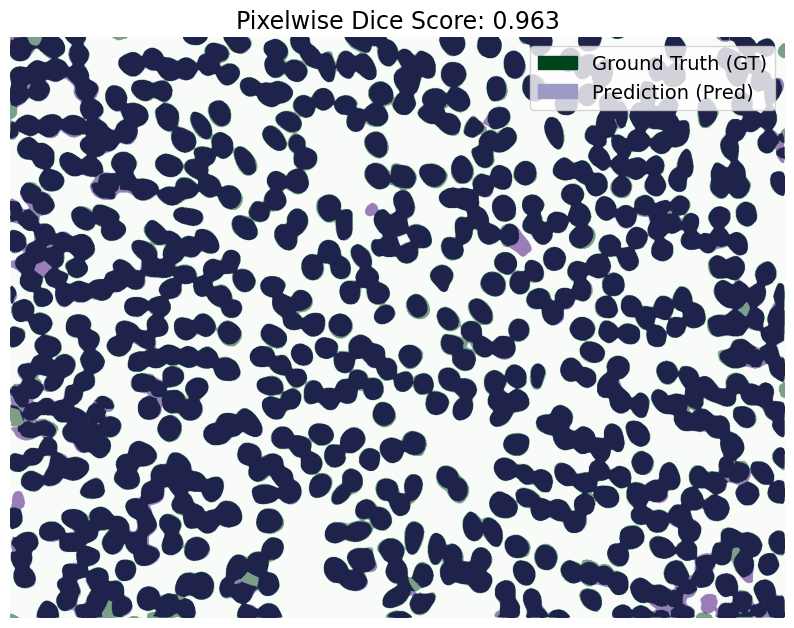

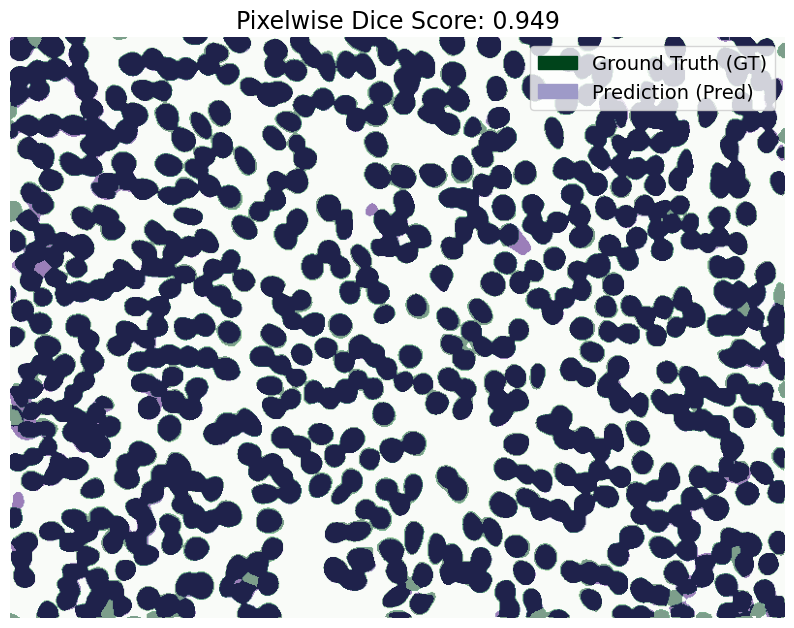

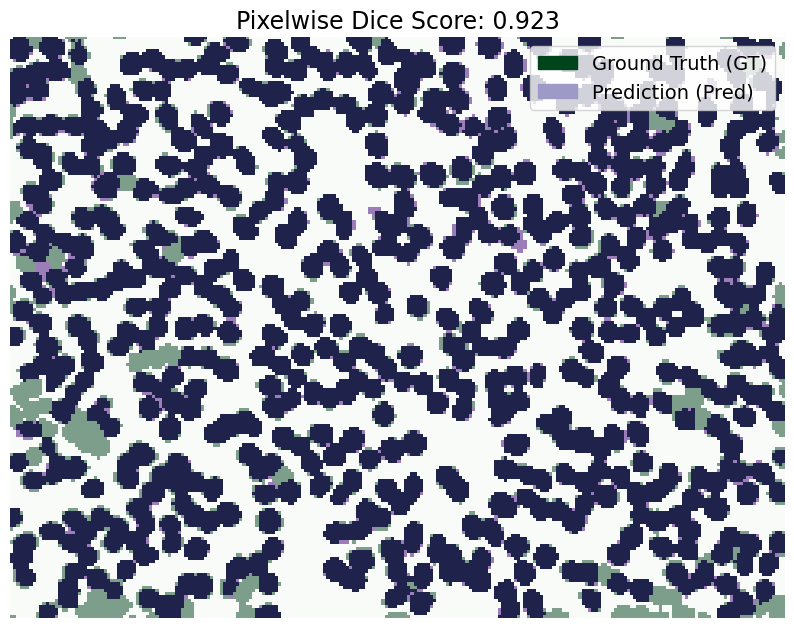

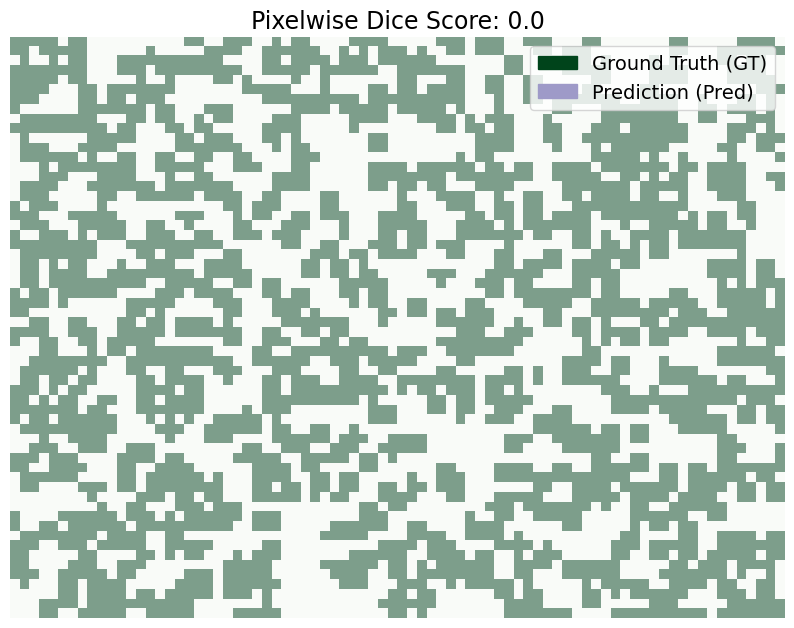

In [13]:
# Import for adding legend patches
from matplotlib.patches import Patch

# List of desired files to process
selected_files = ["T02_Sample1_R.tiff", "T02_Sample1_R_res0_5.tiff", "T02_Sample1_R_res0_15.tiff", "T02_Sample1_R_res0_1.tiff"]

# Loop through the desired files
for file in selected_files:
    # Check if the file is present in the list of images
    if file not in image_names:
        print(f"File {file} not found in the list of images.")
        continue

    # Get the index of the current file
    idx = image_names.index(file)

    # Extract the ground truth (target) and prediction masks
    target_image = test_labels[idx]
    prediction = loaded_masks[idx]

    # Convert ground truth and prediction into binary masks
    target_image_mask = np.where(target_image > 0, 255, 0)  # Convert values > 0 to 255 (binary)
    prediction_mask = np.where(prediction > 0, 255, 0)      # Convert values > 0 to 255 (binary)

    # Calculate the Dice Score
    dice_score = calculate_dice(target_image, prediction)

    # Create the overlay figure
    plt.figure(figsize=(10, 10))  # Set figure size
    plt.axis('off')  # Remove axes for better visualization

    # Display the ground truth and prediction masks as overlays
    target_plot = plt.imshow(target_image_mask, cmap='Greens', label="Ground Truth")  # Ground truth in green
    prediction_plot = plt.imshow(prediction_mask, alpha=0.5, cmap='Purples', label="Prediction")  # Prediction in purple with transparency

    # Extract colors directly from the colormap for the legend
    green_patch = Patch(color=target_plot.cmap(1.0), label='Ground Truth (GT)')  # Green color from Greens colormap
    purple_patch = Patch(color=prediction_plot.cmap(0.5), label='Prediction (Pred)')  # Purple color from Purples colormap

    # Add a legend to the plot
    plt.legend(handles=[green_patch, purple_patch], loc="upper right", fontsize=14)

    # Add a title with the Dice Score
    plt.title(f"Pixelwise Dice Score: {round(dice_score, 3)}", fontsize=17)

    # Save the overlay as a PDF file
    #plt.savefig(f"/content/gdrive/MyDrive/CELLPOSE/dataset_09/{file}_overlay.pdf", format="pdf", bbox_inches="tight")

    # Display the overlay
    plt.show()


## Summary of Segmentation Results Across All Evaluation Files for Different Resolutions and Imaging Modes

In [14]:
import re
# Load the QC DataFrame
df = pd.read_csv(csv_path)

# Map the Pixel Dimensions to percentages
df['Resolution (%)'] = df['Pixel Dimensions'].map(resolution)

# Categorize based on image name, ensuring the name contains one of '_R', '_S', or '_T' followed by either '_' or '.'
def get_mode(x):
    if re.search(r'_R[_\.]', x):
        return 'R'
    elif re.search(r'_S[_\.]', x):
        return 'S'
    elif re.search(r'_T[_\.]', x):
        return 'T'
    else:
        raise ValueError(f"Image name does not contain a valid mode (_R, _S, _T) followed by '_' or '.': {x}")

df['Mode'] = df['Image'].apply(get_mode)
# Add the Group column by extracting the first three characters of the Image name
df['Group'] = df['Image'].str[:3]

## Panoptic Quality Score (Dice ≥ 0.8)

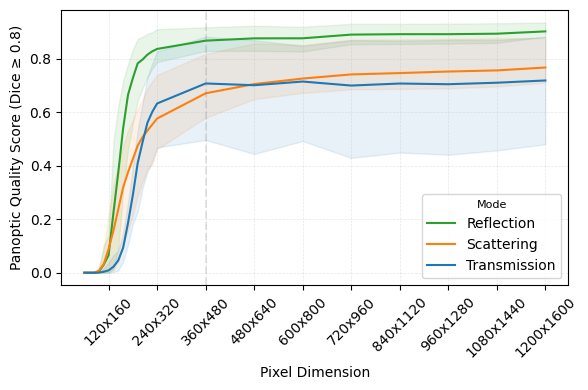

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example legend labels for different modes
legend_labels = {
    'R': 'Reflection',
    'S': 'Scattering',
    'T': 'Transmission',
}

# Define new color palette
colors = {
    'R': sns.color_palette("tab10")[2],  # Blue
    'S': sns.color_palette("tab10")[1],  # Orange
    'T': sns.color_palette("tab10")[0],  # Green
}

# Define a new figure size (larger for better readability)
plt.figure(figsize=(6, 4))  # Larger size for better visibility

for mode in df['Mode'].unique():
    mode_data = df[df['Mode'] == mode]
    stats = mode_data.groupby('Resolution (%)')['Panoptic_quality'].agg(['mean', 'min', 'max']).reset_index()

    # Plot the mean line
    plt.plot(
        stats['Resolution (%)'],
        stats['mean'],
        label=f"{legend_labels.get(mode, mode)}",
        color=colors.get(mode, 'gray'),
        linestyle='-',
        linewidth=1.5  # Thicker line for better visibility
    )

    # Plot shaded areas (without adding them to the legend)
    plt.fill_between(
        stats['Resolution (%)'],
        stats['min'],
        stats['max'],
        color=colors.get(mode, 'gray'),
        alpha=0.1  # Transparency for shaded area
    )

# Add a gray dashed vertical line at 30% resolution
plt.axvline(x=30, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)

# Set axis titles and plot labels
plt.xlabel('Pixel Dimension', fontsize=10)  # Slightly larger font size
plt.ylabel('Panoptic Quality Score (Dice ≥ 0.8)', fontsize=10)  # Slightly larger font size
# plt.title('Panoptic Quality vs Image Resolution\n(5 Images per Mode)', fontsize=12)  # Larger title

# Only show lines in the legend
handles, labels = plt.gca().get_legend_handles_labels()
line_handles = handles[:len(df['Mode'].unique())]  # Only select the lines
line_labels = labels[:len(df['Mode'].unique())]    # Only the corresponding labels
plt.legend(line_handles, line_labels, title="Mode", fontsize=10, title_fontsize=8, loc='lower right')

# Adjust x-axis
plt.xticks(
    ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    labels=['120x160', '240x320', '360x480', '480x640', '600x800', '720x960', '840x1120', '960x1280', '1080x1440', '1200x1600'],
    fontsize=10,  # Slightly larger font size
    rotation=45
)

# Adjust y-axis
plt.yticks(fontsize=10)

# Add grid and adjust layout
plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)  # Thin grid for better readability
plt.tight_layout()


# Save the plot as a PDF
#plt.savefig("/content/gdrive/MyDrive/CELLPOSE/dataset_09/Panoptic.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


## Pixel-wise Dice Score

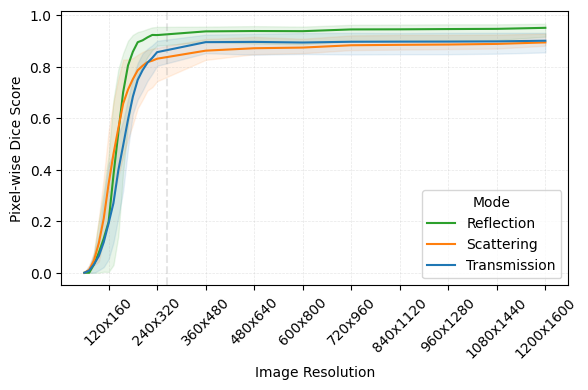

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a new color palette for different modes
colors = {
    'R': sns.color_palette("tab10")[2],  # Blue
    'S': sns.color_palette("tab10")[1],  # Orange
    'T': sns.color_palette("tab10")[0],  # Green
    'Other': sns.color_palette("tab10")[3]  # Red
}

# Define a larger figure size for better visibility
plt.figure(figsize=(6, 4))  # Larger size for better readability

# Iterate over the unique modes
for mode in df['Mode'].unique():
    mode_data = df[df['Mode'] == mode]
    # Group data by resolution and calculate mean, min, and max of Dice score
    stats = mode_data.groupby('Resolution (%)')['Dice (Pix-Lev)'].agg(['mean', 'min', 'max']).reset_index()

    # Plot the mean Dice score as a line
    plt.plot(
        stats['Resolution (%)'],
        stats['mean'],
        label=f"{legend_labels.get(mode, mode)}",  # Get the label for the mode
        color=colors.get(mode, 'gray'),  # Assign the color from the palette
        linestyle='-',  # Solid line
        linewidth=1.5  # Thicker line for better visibility
    )

    # Plot shaded areas for the min and max values (without adding to the legend)
    plt.fill_between(
        stats['Resolution (%)'],
        stats['min'],
        stats['max'],
        color=colors.get(mode, 'gray'),  # Use the corresponding color for shading
        alpha=0.1  # Transparency for the shaded area
    )

# Add a gray dashed vertical line at 22% resolution
plt.axvline(x=22, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)

# Set axis labels and plot titles
plt.xlabel('Image Resolution', fontsize=10)  # Slightly larger font size for x-axis
plt.ylabel('Pixel-wise Dice Score', fontsize=10)  # Slightly larger font size for y-axis
#plt.title('Pixel-wise Dice Score vs Image Resolution\n(5 Images per Mode)', fontsize=12)  # Larger title (optional)

# Only include lines in the legend (no shaded areas)
handles, labels = plt.gca().get_legend_handles_labels()
line_handles = handles[:len(df['Mode'].unique())]  # Only select the lines
line_labels = labels[:len(df['Mode'].unique())]    # Only the corresponding labels
# Set the legend with the selected lines
plt.legend(line_handles, line_labels, title="Mode", fontsize=10, title_fontsize=10, loc='lower right')

# Adjust x-axis ticks and labels for better readability
plt.xticks(
    ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    labels=['120x160', '240x320', '360x480', '480x640', '600x800', '720x960', '840x1120', '960x1280', '1080x1440', '1200x1600'],
    fontsize=10,  # Slightly larger font size for x-axis
    rotation=45  # Rotate labels for better visibility
)

# Adjust y-axis ticks font size for better readability
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)  # Thin grid lines with light transparency
# Apply tight layout to prevent clipping
plt.tight_layout()

# Save the plot as a PDF file
#plt.savefig("/content/gdrive/MyDrive/CELLPOSE/dataset_09/Dice.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


## F1 Score (Dice ≥ 0.8)

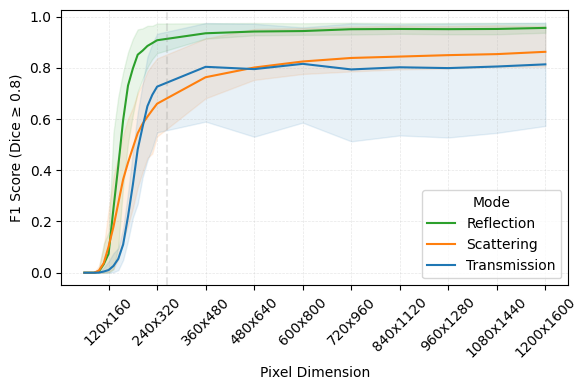

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a new color palette for different modes
colors = {
    'R': sns.color_palette("tab10")[2],  # Blue
    'S': sns.color_palette("tab10")[1],  # Orange
    'T': sns.color_palette("tab10")[0],  # Green
    'Other': sns.color_palette("tab10")[3]  # Red
}

# Set the figure size for better visibility
plt.figure(figsize=(6, 4))  # Larger figure size for improved readability

# Iterate over the unique modes in the DataFrame
for mode in df['Mode'].unique():
    # Filter data for the current mode
    mode_data = df[df['Mode'] == mode]
    # Group the data by resolution and calculate mean, min, and max for F1 score
    stats = mode_data.groupby('Resolution (%)')['F1 Score'].agg(['mean', 'min', 'max']).reset_index()

    # Plot the mean F1 score as a line
    plt.plot(
        stats['Resolution (%)'],
        stats['mean'],
        label=f"{legend_labels.get(mode, mode)}",  # Get the label for the mode from the legend dictionary
        color=colors.get(mode, 'gray'),  # Assign color from the defined palette
        linestyle='-',  # Solid line style
        linewidth=1.5  # Make the line thicker for better visibility
    )

    # Plot the shaded area representing the min-max range (without adding to the legend)
    plt.fill_between(
        stats['Resolution (%)'],
        stats['min'],
        stats['max'],
        color=colors.get(mode, 'gray'),  # Use the corresponding color for shading
        alpha=0.1  # Set transparency for the shaded area
    )

# Add a gray dashed vertical line at 22% resolution
plt.axvline(x=22, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)

# Set axis labels and font sizes
plt.xlabel('Pixel Dimension', fontsize=10)  # Slightly larger font size for x-axis
plt.ylabel('F1 Score (Dice ≥ 0.8)', fontsize=10)  # Slightly larger font size for y-axis
# Uncomment the following line if a title is needed
# plt.title('F1 Score vs Image Resolution\n(5 Images per Mode)', fontsize=12)

# Display only the lines in the legend (exclude shaded areas)
handles, labels = plt.gca().get_legend_handles_labels()
line_handles = handles[:len(df['Mode'].unique())]  # Select only the line handles
line_labels = labels[:len(df['Mode'].unique())]    # Select corresponding labels
# Create the legend with the selected lines
plt.legend(line_handles, line_labels, title="Mode", fontsize=10, title_fontsize=10, loc='lower right')

# Adjust x-axis ticks and labels for better readability
plt.xticks(
    ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    labels=['120x160', '240x320', '360x480', '480x640', '600x800', '720x960', '840x1120', '960x1280', '1080x1440', '1200x1600'],
    fontsize=10,  # Slightly larger font size for x-axis labels
    rotation=45  # Rotate labels for better visibility
)

# Adjust y-axis ticks font size for better readability
plt.yticks(fontsize=10)

# Add a grid for better visibility of the plot
plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)  # Thin grid lines with some transparency
# Apply tight layout to prevent clipping of labels and content
plt.tight_layout()

# Save the plot as a PDF
#plt.savefig("/content/gdrive/MyDrive/CELLPOSE/dataset_09/F1.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


## Panoptic Quality Score (Dice ≥ 0.8) across Reflection, Transmission and Scattering Mode

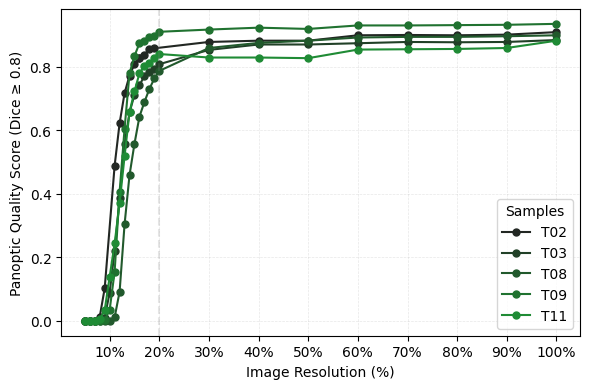

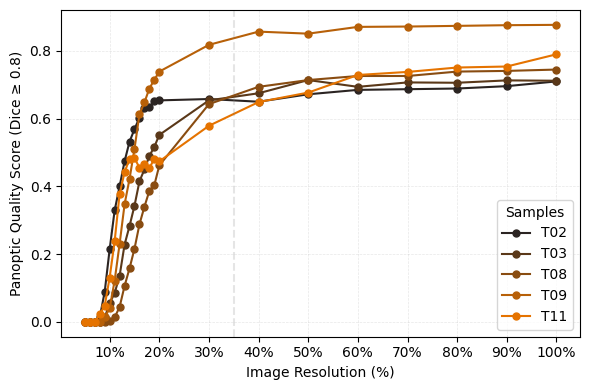

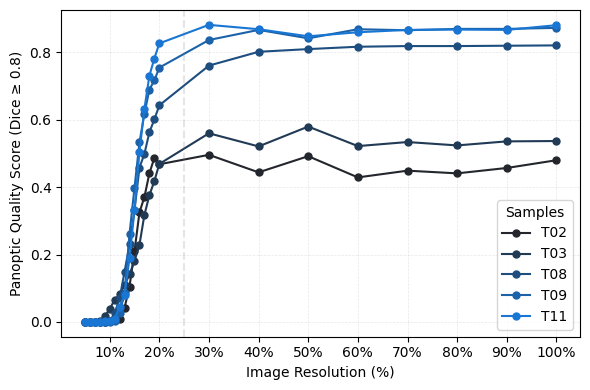

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palettes for different modes
color_palettes = {
    'R': sns.color_palette("dark:#1f8b35", n_colors=5),  # Dark green to green
    'S': sns.color_palette("dark:#e57300", n_colors=5),  # Dark orange to orange
    'T': sns.color_palette("dark:#1976d2", n_colors=5),  # Dark blue to blue
}

# Define the figure size
figsize = (6, 4)

# Define the groups to be plotted
groups = ['T02', 'T03', 'T08', 'T09', 'T11']

# Create a separate plot for each mode
for mode in df['Mode'].unique():
    # Filter data by mode
    mode_data = df[df['Mode'] == mode]

    # Apply filter for the desired groups
    mode_data_filtered = mode_data[mode_data['Group'].isin(groups)]

    # Create a new figure for each mode
    plt.figure(figsize=figsize)

    # Iterate over groups and plot the lines for each group
    for idx, group_id in enumerate(groups):
        # Filter data by group
        group_data = mode_data_filtered[mode_data_filtered['Group'] == group_id]

        # Sort data by resolution
        group_data_sorted = group_data.sort_values('Resolution (%)')

        # Select color based on mode
        color = color_palettes[mode][idx % len(color_palettes[mode])]

        # Plot the line for the group with markers
        plt.plot(
            group_data_sorted['Resolution (%)'],
            group_data_sorted['Panoptic_quality'],  # Alternatively: 'Dice_score' or 'F1_score'
            label=f"{group_id}",
            color=color,
            linestyle='-',  # Solid line
            linewidth=1.5,  # Thicker line for better visibility
            marker='o',  # Circle markers for each data point
            markersize=5  # Size of the markers
        )

    # Add a vertical dashed line to indicate a specific threshold for each mode
    if mode == 'R':
        plt.axvline(x=20, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)  # Threshold for Reflection
    elif mode == 'S':
        plt.axvline(x=35, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)  # Threshold for Scattering
    elif mode == 'T':
        plt.axvline(x=25, color='gray', linestyle='--', linewidth=1.5, alpha=0.2)  # Threshold for Transmission

    # Set the title for the mode
    mode_title = {"R": "Reflection", "S": "Scattering", "T": "Transmission"}.get(mode, mode)

    # Add axis labels and titles
    plt.xlabel('Image Resolution (%)', fontsize=10)  # X-axis label with appropriate font size
    plt.ylabel('Panoptic Quality Score (Dice ≥ 0.8)', fontsize=10)  # Y-axis label with appropriate font size

    # Add legend with title and font size
    plt.legend(title="Samples", fontsize=10, title_fontsize=10, loc='lower right')

    # Adjust X-axis ticks and labels
    plt.xticks(
        ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
        fontsize=10  # Font size for X-axis labels
    )

    # Adjust Y-axis tick font size
    plt.yticks(fontsize=10)

    # Add a grid for better readability of the plot
    plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)  # Thin dashed grid lines with transparency

    # Apply tight layout to avoid clipping of labels and content
    plt.tight_layout()

    # Save the plot as a PDF with the mode's name
    #plt.savefig(f"/content/gdrive/MyDrive/CELLPOSE/dataset_09/{mode}.pdf", format="pdf", bbox_inches="tight")

    # Display the plot
    plt.show()
